In [31]:
import numpy as np
import matplotlib.pyplot as plt

import json

## Household Demand class 

In [33]:
def get_temperature(day_of_year):
    return 30

class DemandForecast:
    def __init__(self):
        self.load_config()

        hp = self.DEMAND_CONFIG["household_parameters"]
        self.house_scale = np.random.uniform(*hp["scale_range"])
        self.peak_kw = np.random.uniform(*hp["peak_kw_range"])

    def load_config(self):
        with open("src\demand_config.json", "r") as f:
            self.DEMAND_CONFIG = json.load(f)   
        self.PROFILE = self.DEMAND_CONFIG["daily_profile"]

    def get_load(self, hour, day_of_week, day_of_year):
        base = self.PROFILE[hour] * self.peak_kw * self.house_scale

        # stochastic noise
        noise = np.random.normal(0, self.DEMAND_CONFIG["noise_std"])
        load = base * (1 + noise)


        # temperature effect
        temperature = get_temperature(day_of_year)
        temp_cfg = self.DEMAND_CONFIG["temperature_effect"]
        if temperature > temp_cfg["threshold"]:
            load += temp_cfg["sensitivity"] * (temperature - temp_cfg["threshold"])


        # appliances
        appliances = self.DEMAND_CONFIG["appliances"]

        # cooking
        cook = appliances["cooking"]
        if hour in cook["hours"] and np.random.rand() < cook["probability"]:
            load += cook["load_kw"]


        # AC
        ac = appliances["ac"]
        if hour in ac["hours"] and np.random.rand() < ac["probability"]:
            load += np.random.uniform(*ac["load_kw_range"])


        # water pump (any hour)
        pump = appliances["pump"]
        if np.random.rand() < pump["probability"]:
            load += pump["load_kw"]


        # weekend effect
        if day_of_week in [5, 6]:
            load *= self.DEMAND_CONFIG["weekend_multiplier"]


        return max(load, self.DEMAND_CONFIG["minimum_load"])

## Single Day demand curve 

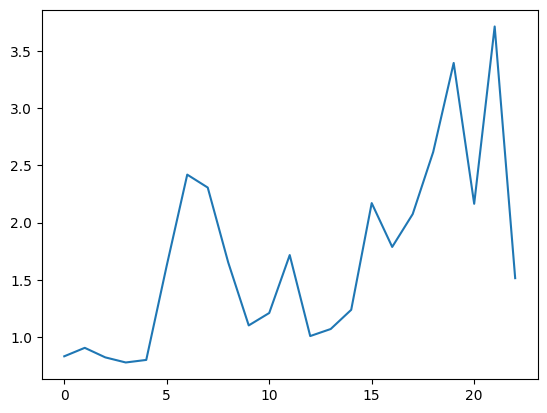

In [36]:
house = DemandForecast()
demand = []
for hour in range(0, 23):
    demand.append(house.get_load(hour, day_of_week=1, day_of_year=2))
    
plt.plot(np.array([hour for hour in range(0,23)]), demand)

## Average curve over 1000 days

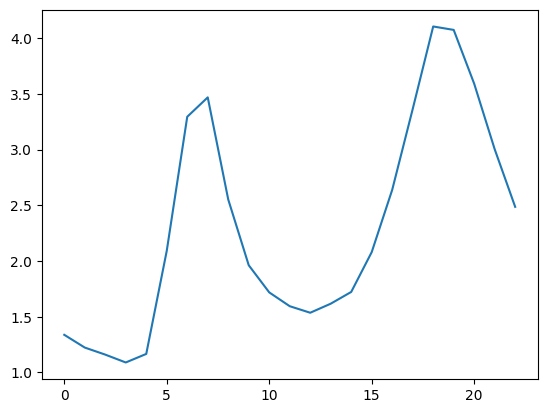

In [ ]:
house = DemandForecast()
days_demand = []
for day in range(0, 1000):
    daily_load = []
    for hour in range(0, 23):
        load = house.get_load(hour, day_of_week=day%7, day_of_year=day%365)
        daily_load.append(load)
    days_demand.append(daily_load)


def get_average(days_demand):
    average_demand = []
    for hour in range(0,23):
        hour_demand = [day[hour] for day in days_demand]
        average_demand.append(np.mean(hour_demand))
    return average_demand

plt.plot(np.array([hour for hour in range(0,23)]), get_average(days_demand))